# AlexNet - CIFAR10 - keras


The goal of this implementation is to study the impact of model's architecture and how does the hyperparameter works together to improve a model performance.

> Therefore, the optimisation is defined and fixed. We'll use Adam optimiser with a `learning_rate` of .0003

## Imports

In [1]:
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
!pip freeze | grep -e "tensorflow==" -e "keras=="

keras==2.10.0


In [4]:
import tensorflow as tf

from tensorflow.keras import layers, Model, Input, callbacks
from tensorflow.keras.regularizers import L2

2023-02-01 15:39:23.331073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 15:39:23.416727: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-01 15:39:23.796194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-01 15:39:23.796232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [5]:
from tqdm.keras import TqdmCallback

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU: {device_name}')

Found GPU: /device:GPU:0


2023-02-01 15:39:24.549321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 15:39:24.612263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:39:24.626874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:39:24.627034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import numpy as np

## Load and prepare data

In [10]:
# Load data
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()

In [11]:
no_classes = 10
classe_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [12]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [13]:
# Normalize pixel values to be between 0 and 1
x_train, x_val = x_train / 255.,  x_val / 255.
y_train, y_val = y_train.flatten(), y_val.flatten()

In [14]:
# Fixing seed for Python, NumPy, and TensorFlow
seed = 0
tf.keras.utils.set_random_seed(seed)

In [15]:
# # Split train val
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=0)

In [16]:
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

print("\nx_val.shape:", x_val.shape)
print("y_val.shape", y_val.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)

x_val.shape: (10000, 32, 32, 3)
y_val.shape (10000,)


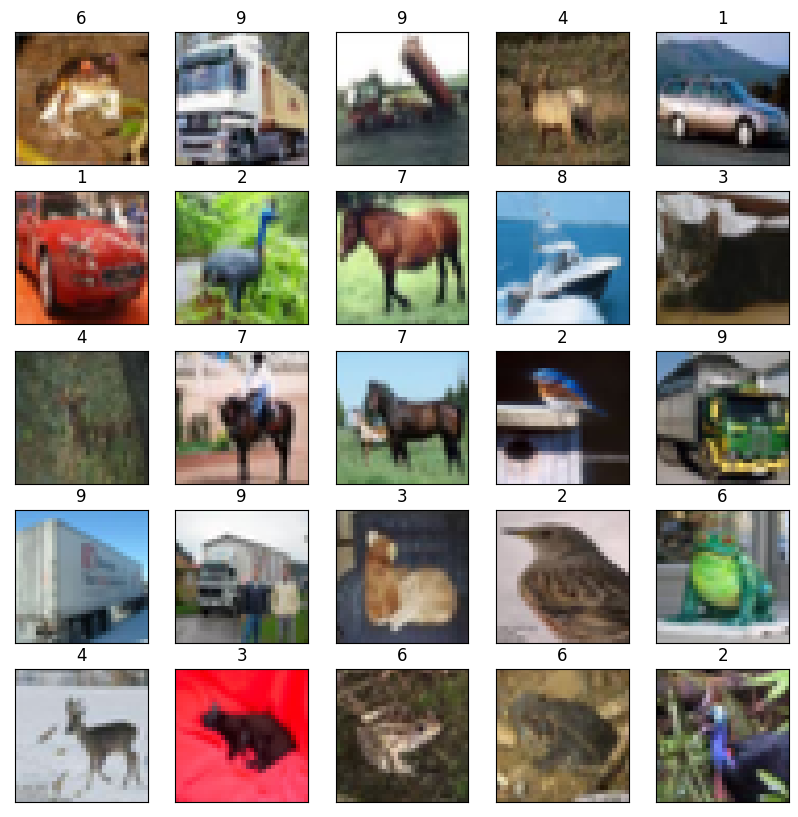

In [17]:
# Plot grid with first 25 training images with their corresponding label
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(y_train[i])
plt.show()

## Building architecture then model

### Adam optimizer - Fixed 3e-4 learning_rate

In [18]:
model_name = 'alexnet-adam-fixed'
batch_size = 512
epochs = 100
dropout_rate = .25
regularization_coef = .0005

In [19]:
def get_alexnet(input_shape=(32, 32, 3)):
    X_input = layers.Input(input_shape)
    X = layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.MaxPooling2D((3, 3))(X)

    X = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.MaxPooling2D((2, 2))(X)
    
    X = layers.Conv2D(filters=384, kernel_size=(5, 5), strides=(1, 1), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(filters=384, kernel_size=(5, 5), strides=(1, 1), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((2, 2))(X)
    
    ### Prediction bloc
    X = layers.Flatten()(X)
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(no_classes)(X)
    X_output = layers.Activation('softmax')(X)
    return Model(inputs=[X_input], outputs=[X_output], name='alexnet')

In [20]:
img_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
img_shape

(32, 32, 3)

In [21]:
model = get_alexnet(img_shape)
model.summary()

Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       19456     
                                                                 
 activation_4 (Activation)   (None, 32, 32, 256)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 4096)              268439552 
                                                           

2023-02-01 14:50:01.792047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:50:01.792224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:50:01.792353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:50:01.792605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:50:01.792747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [ ]:
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(3e-4)
metric = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_acc')
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25),
    TqdmCallback(verbose=0)
]

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

start_time = time.time()
results = model.fit(
    x_train, y_train,
    batch_size, epochs, 
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=0 # Supress fitting information
)

predictions = model.predict(x_val)
print(f'Execution time: {round((time.time() - start_time)/60, 2)}min')

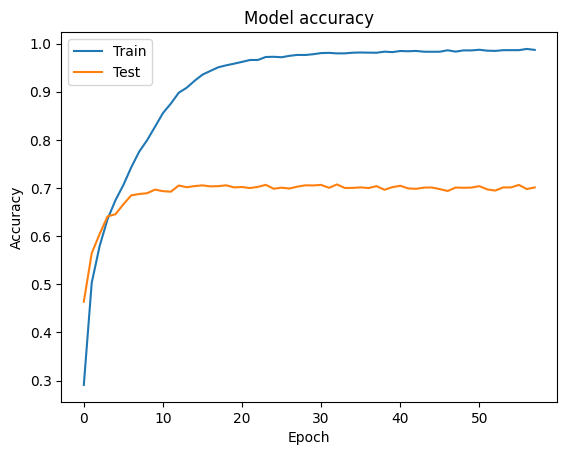

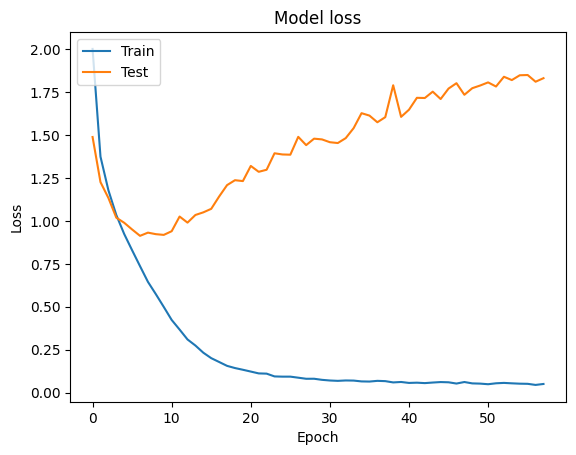

In [24]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
flat_preds= np.argmax(predictions, axis=1)
flat_preds.shape

(10000,)

In [27]:
confusion = confusion_matrix(y_val, flat_preds)
confusion

array([[749,  18,  44,  23,  20,   6,   9,   5,  91,  35],
       [ 12, 837,   2,  12,   4,   6,   6,   1,  42,  78],
       [ 71,   8, 523,  82, 110,  79,  67,  26,  21,  13],
       [ 32,  19,  43, 549,  64, 176,  45,  29,  21,  22],
       [ 21,   3,  66,  87, 673,  31,  52,  47,  15,   5],
       [ 19,  10,  41, 172,  47, 607,  27,  49,  20,   8],
       [  8,  16,  36,  75,  61,  36, 741,   6,  15,   6],
       [ 16,   9,  28,  42,  86,  57,   5, 731,   7,  19],
       [ 55,  36,   8,  18,   3,   9,   7,   2, 843,  19],
       [ 33, 104,  10,  16,   8,   5,   4,  11,  51, 758]])

Accuracy on unseen data: 17.52%


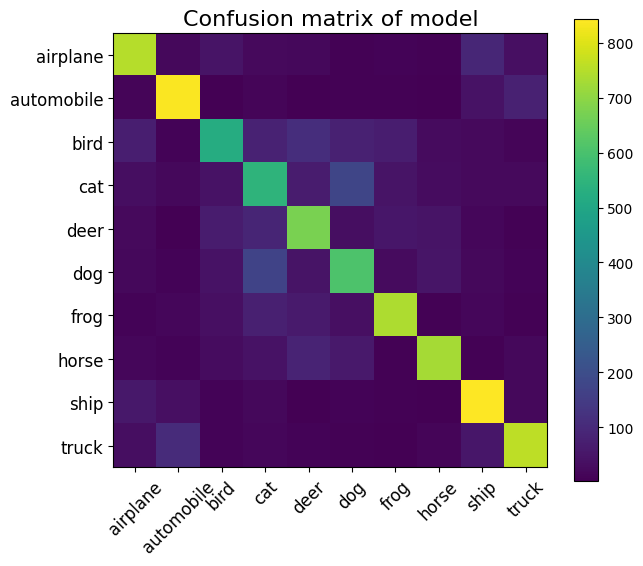

In [28]:
print(f'Accuracy on validation set: {metric.result()*10.:.2f}%')

plt.figure(figsize=(7, 6))
plt.title(f'Confusion matrix of model', fontsize=16)
plt.imshow(confusion)
plt.xticks(np.arange(10), classe_names, rotation=45, fontsize=12)
plt.yticks(np.arange(10), classe_names, fontsize=12)
plt.colorbar()
plt.show()

In [ ]:
model_file = f'{model_name}.h5'
print(f'Saving model to the current directory under {model_file} file')
model.save(f'{model_file}')

### SGD optimizer - Original variable learning_rate

In [18]:
model_name = 'alexnet-sgd-var'
batch_size = 512
epochs = 100
dropout_rate = .25
regularization_coef = .0005

momentum = .9
learning_rate = .01
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.01, patience=3, min_lr=1e-5)

In [19]:
def get_alexnet(input_shape=(32, 32, 3)):
    X_input = layers.Input(input_shape)
    X = layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.MaxPooling2D((3, 3))(X)

    X = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.MaxPooling2D((2, 2))(X)
    
    X = layers.Conv2D(filters=384, kernel_size=(5, 5), strides=(1, 1), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(filters=384, kernel_size=(5, 5), strides=(1, 1), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), kernel_regularizer=L2(regularization_coef), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((2, 2))(X)
    
    ### Prediction bloc
    X = layers.Flatten()(X)
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(no_classes)(X)
    X_output = layers.Activation('softmax')(X)
    return Model(inputs=[X_input], outputs=[X_output], name=model_name)

In [20]:
img_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
img_shape

(32, 32, 3)

In [21]:
model = get_alexnet(img_shape)
model.summary()

Model: "alexnet-sgd-var"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       19456     
                                                                 
 activation_4 (Activation)   (None, 32, 32, 256)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 4096)              268439552 
                                                   

2023-02-01 15:39:32.385545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:39:32.385785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:39:32.385955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:39:32.386306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:39:32.386492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [22]:
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum)
metric = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_acc')
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25),
    lrr,
    TqdmCallback(verbose=0)
]

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

start_time = time.time()
results = model.fit(
    x_train, y_train,
    batch_size, epochs, 
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=0 # Supress fitting information
)

predictions = model.predict(x_val)
print(f'Execution time: {round((time.time() - start_time)/60, 2)}min')

0epoch [00:00, ?epoch/s]

2023-02-01 15:39:34.437694: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-02-01 15:39:35.015413: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-01 15:39:35.015443: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


313/313 [==============================] - 1s 3ms/step
Execution time: 16.4min


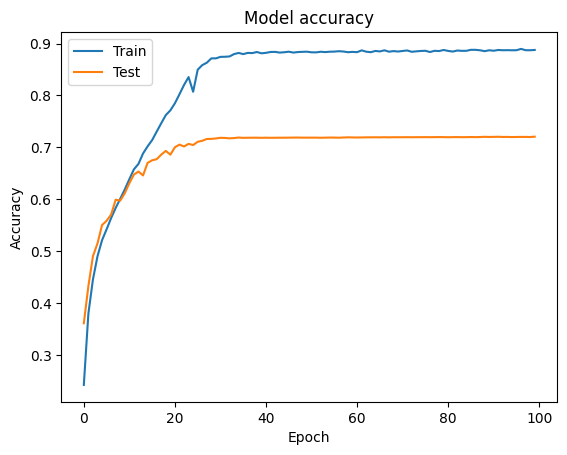

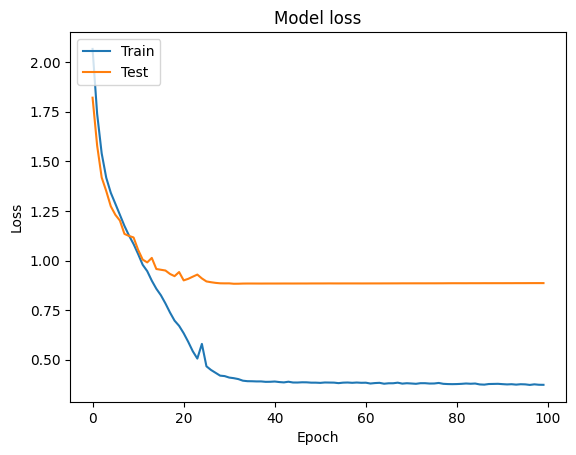

In [23]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
flat_preds= np.argmax(predictions, axis=1)
flat_preds.shape

(10000,)

In [25]:
confusion = confusion_matrix(y_val, flat_preds)
confusion

array([[781,  15,  32,  21,  16,   7,  16,   8,  63,  41],
       [ 15, 817,   9,  15,   4,   5,   8,   3,  28,  96],
       [ 66,   7, 575,  58, 102,  62,  71,  38,   9,  12],
       [ 16,  18,  70, 536,  52, 172,  68,  35,  12,  21],
       [ 20,   1,  75,  57, 673,  33,  67,  56,  15,   3],
       [ 16,   3,  48, 171,  49, 613,  34,  47,   7,  12],
       [  8,   8,  39,  53,  31,  26, 816,   6,   8,   5],
       [ 19,   4,  29,  31,  58,  51,   3, 790,   4,  11],
       [ 59,  40,  10,  12,   8,   7,   5,   3, 826,  30],
       [ 34,  91,   8,  16,   4,   7,   8,  20,  32, 780]])

Accuracy on validation set: 0.0%


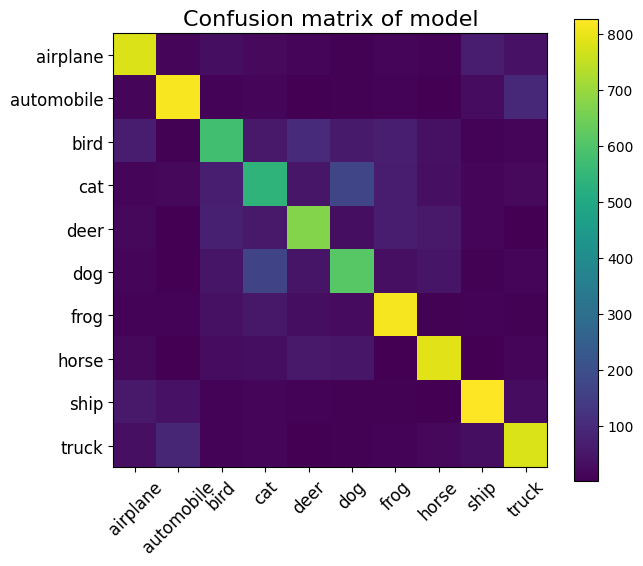

In [27]:
print(f'Accuracy on validation set: {metric.result().numpy()}%')

plt.figure(figsize=(7, 6))
plt.title(f'Confusion matrix of model', fontsize=16)
plt.imshow(confusion)
plt.xticks(np.arange(10), classe_names, rotation=45, fontsize=12)
plt.yticks(np.arange(10), classe_names, fontsize=12)
plt.colorbar()
plt.show()

In [28]:
model_file = f'{model_name}.h5'
print(f'Saving model to the current directory under {model_file} file')
model.save(f'{model_file}')

Saving model to the current directory under alexnet-sgd-var.h5 file


2023-02-01 15:56:20.063078: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.
2023-02-01 15:56:20.779808: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.
